### MScFE 690 Capstone -- Final Submission

### 1. Imports

In [4]:
import nolds
import pandas as pd
import numpy as np
import math
from fbm import *
from fbm import FBM
import yfinance as yf
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'arial'
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)
from sklearn.exceptions import UndefinedMetricWarning
warnings.simplefilter(action='ignore', category=UndefinedMetricWarning)
def filter_ransac_warning(message, category, filename, lineno, file=None, line=None):
    return "RANSAC did not reach consensus" not in str(message)
warnings.filterwarnings("ignore", message=".*RANSAC did not reach consensus.*", category=RuntimeWarning)

The MMAR or Multifractal Model of Asset Returns utilizes a compound process denoted as \(X(t)\). This is presented mathematically as:

$$ X(t) = B_H(\theta(t)) $$

Here are the components of the equation:

- \(X(t)\) is our compound process. This signifies the cumulative effect of multiple time scales.
- \(B_H(t)\) is what we call a fractional Brownian motion. This is a variation of a Gaussian process and a generalization of the standard Brownian motion. The Hurst exponent, denoted by \(H\) (with \(0 < H < 1\)), characterizes this motion. A Hurst exponent of \(0.5\) turns \(B_H(t)\) into a standard Brownian motion, while a Hurst exponent less than \(0.5\) indicates negative correlation in the process increments, and a Hurst exponent greater than \(0.5\) suggests positive correlation.
- Lastly, \(\theta(t)\) corresponds to the cumulative distribution function of a specific multifractal cascade measure. This is crucial as it dictates the changing "pace" of the fractional Brownian motion. The precise form of \(\theta(t)\) is contingent on the multifractal cascade measure in use, which itself depends on the distinct properties of the financial time series under study.

### 2. A Look a Fractal Brownian Motion

#### 2.1. Simple FBM Simulation using Nolds

Fractional Brownian Motion can be described as a "walk" where the next step might be influenced by previous steps. This could be for example in the form of momentum or reversion. This introduction of "memory" via the hurst exponent aims to model this well-known memory feature of financial markets. FBM is compontent of the MMAR that will be described in the following sections.

In [5]:
fbm = nolds.fbm(100, H=0.75)

In [6]:
fbm = pd.Series(fbm)

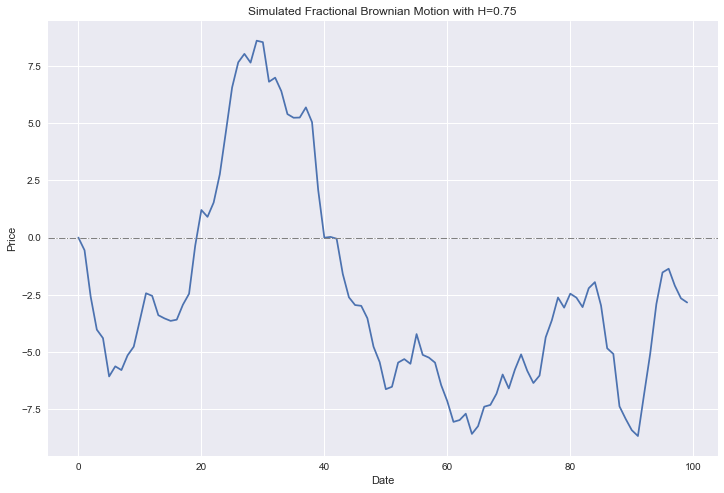

In [7]:
plt.figure(figsize=(12, 8))
plt.plot(fbm)
plt.axhline(y=0.0, color='grey', linestyle='-.', linewidth=1)
plt.title('Simulated Fractional Brownian Motion with H=0.75')
# plt.legend(loc=0)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

#### 2.2. Importing Oil Prices

In [27]:
ticker_symbol = 'CL=F'
start_date = '1990-01-01'
end_date = '2023-06-30'
data = yf.download(ticker_symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [28]:
prices = data['Adj Close']

In [10]:
prices.describe()

count    5737.000000
mean       63.828126
std        25.614463
min       -37.630001
25%        44.480000
50%        61.450001
75%        83.629997
max       145.289993
Name: Adj Close, dtype: float64

#### 2.3. The Hurst Exponent: Calculating Oil's Hurst Exponent

The Hurst exponent \(H\) is a statistical measure used to classify time series data. It can help in determining the nature of a given time series:

- \(H < 0.5\): The time series has a tendency to revert to a mean (negative autocorrelation).
- \(H = 0.5\): The time series follows a random walk (Brownian motion).
- \(H > 0.5\): The time series shows a persistent behavior (positive autocorrelation).

However, different lenghts of timeseries should generate different values of Hurst Exponent. This is due to the fact that the same underlying process (i.e the positive or negative autocorrelation present in the timeseries) can appear differently under different sampling dizes or resolutions. One solution is the one proposed below, where the price data is divided into segments and several calculations of H generating a distribution. 

In [11]:
def segment_data(data, num_segments):
    """
    Splits the data into multiple segments.
    """
    len_segment = len(data) // num_segments
    return [data[i:i+len_segment] for i in range(0, len(data), len_segment) if len(data[i:i+len_segment]) == len_segment]

def calculate_hurst_for_segments(data, num_segments):
    """
    Calculate the Hurst exponent for the segment
    """
    segments = segment_data(data, num_segments)
    hurst_values = [nolds.hurst_rs(seg) for seg in segments]
    return hurst_values

num_segments = 625
hurst_values = calculate_hurst_for_segments(prices, num_segments)

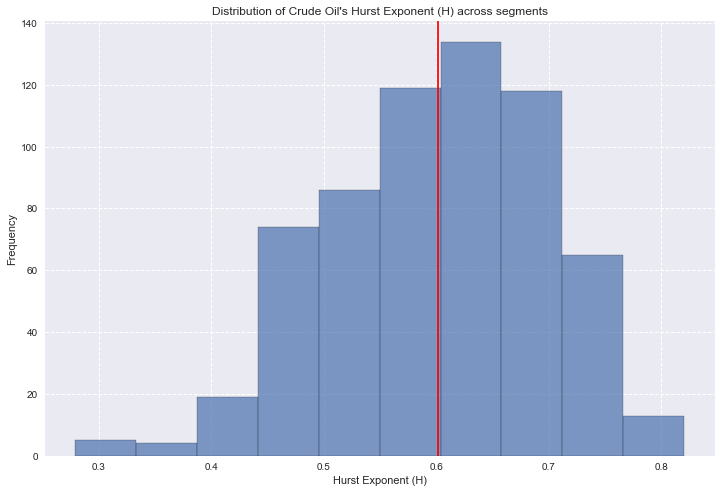

In [12]:
plt.figure(figsize=(12, 8))
plt.hist(hurst_values, bins=10, edgecolor='black', alpha=0.7)
plt.title("Distribution of Crude Oil's Hurst Exponent (H) across segments")
plt.xlabel("Hurst Exponent (H)")
plt.ylabel("Frequency")
plt.axvline(np.mean(hurst_values), color='red')
plt.grid(True, which="both", ls="--")
plt.show()

In [13]:
np.mean(hurst_values)

0.6012417804833374

In [14]:
h_oil = np.mean(hurst_values)

Crude Oil's Hurst Exponenet is seen centered around 0.60, i.e small persistence autocorrelation.

#### 2.4. Simulating A FBM with Oil's H

In [15]:
fbm_oil = nolds.fbm(100, H=np.mean(hurst_values))

In [16]:
fbm_oil = pd.Series(fbm_oil)

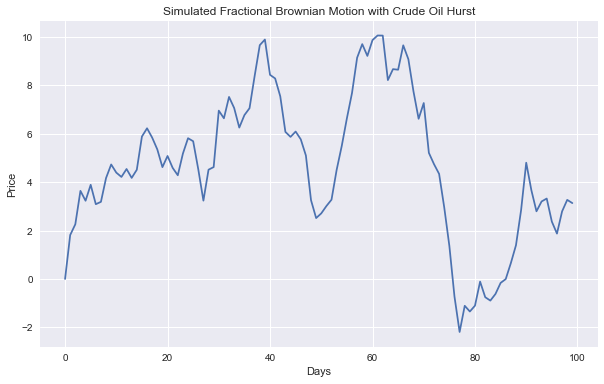

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(fbm_oil)
#plt.axhline(y=0.0, color='grey', linestyle='-.', linewidth=1)
plt.title('Simulated Fractional Brownian Motion with Crude Oil Hurst')
# plt.legend(loc=0)
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

We can see from the above simulation that for any realistic simulation of prices using a FBM, we would need to include a limitation for prices going negative (even though oil prices did go negative in the past!).

To examplify the process of pricing an option using Monte Carlo simulation from a given stochastic model, we will attempt to price an European call option under the assumption that the price of the asset follows a fractional Brownian Motion process (fbm). We will later use the same methodology to calculate the payoff and discounted value for the MMAR simulations:

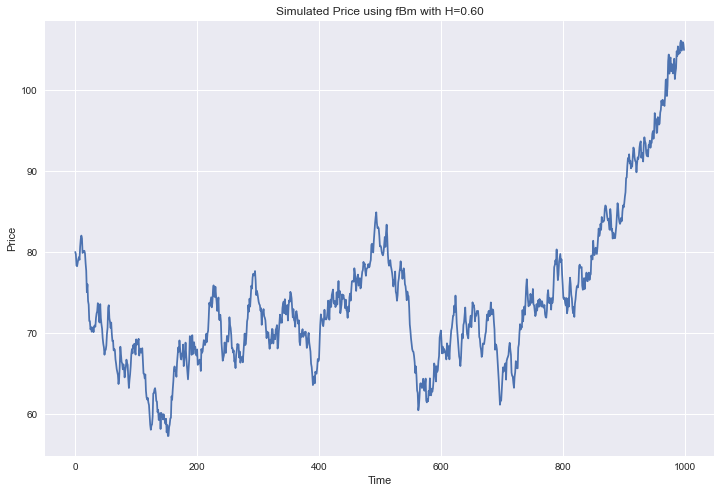

In [18]:
def generate_fbm_path(n, hurst, dt=1, s0=1):
    """Generate a fractional Brownian motion path with n steps and a given Hurst exponent."""
    # Generate Fractional Gaussian Noise using numpy's random.randn
    dW = np.random.randn(n)
    
    # Generate the fBm increments (scales with time as per Hurst exponent)
    increments = dW * (dt**(hurst))
    
    # Construct the fBm path
    fbm_path = np.cumsum(increments)
    
    # Shift the path to start at s0
    fbm_path = fbm_path - fbm_path[0] + s0
    
    return fbm_path

n = 1000  # number of steps
hurst_mean = np.mean(hurst_values)  # Mean Hurst value calculated from earlier
prices = generate_fbm_path(n, hurst_mean, s0=80)

# Imposing floor to ensure prices don't go below 0
prices = np.where(prices > 0, prices, 0)

# Plot the simulated prices
plt.figure(figsize=(12, 8))
plt.plot(prices)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'Simulated Price using fBm with H={hurst_mean:.2f}')
plt.grid(True)
plt.show()

#### 2.5. Pricing Oil Options with FBM and Monte Carlo

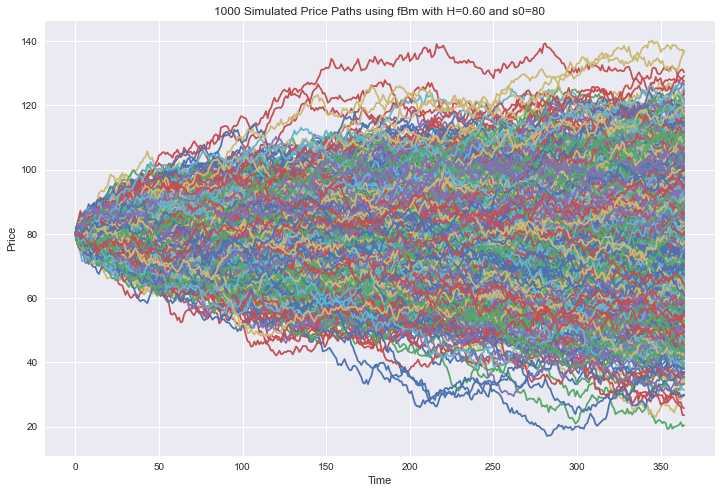

In [19]:
def generate_multiple_paths(num_paths, n, hurst, dt=1, s0=1):
    """Generate multiple fBm paths and plot them."""
    # Create a new plot
    plt.figure(figsize=(12, 8))
    
    # For each path
    for _ in range(num_paths):
        prices = generate_fbm_path(n, hurst, dt, s0)
        # Imposing floor to ensure prices don't go below 0
        prices = np.where(prices > 0, prices, 0)
        plt.plot(prices)
    
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title(f'{num_paths} Simulated Price Paths using fBm with H={hurst:.2f} and s0={s0}')
    plt.grid(True)
    plt.show()

num_paths = 1000 
n = 365  # Number of steps per path
hurst_mean = np.mean(hurst_values)  # Mean Hurst value calculated from earlier
s0 = 80  # Starting price
generate_multiple_paths(num_paths, n, hurst_mean, s0=s0)

In [20]:
def generate_multiple_paths(num_paths, n, hurst, dt=1, S0=1):
    """Generate multiple fBm paths."""
    paths = []
    for _ in range(num_paths):
        prices = generate_fbm_path(n, hurst, dt, S0)
        # Imposing floor to ensure prices don't go below 0
        prices = np.where(prices > 0, prices, 0)
        paths.append(prices)
    return paths

def monte_carlo_option_price(num_paths, n, hurst, dt=1, S0=1, r=0.05, T=1, option_type="call", K=None):
    """Compute European option price using Monte Carlo simulation."""
    if K is None:
        K = S0  # If no strike is provided, assume ATM
    
    total_payoff = 0
    
    # Generate multiple price paths
    paths = generate_multiple_paths(num_paths, n, hurst, dt, S0)
    
    # Calculate total payoff from all paths
    for prices in paths:
        ST = prices[-1]  # Price at expiration
        
        # Payoff calculation
        if option_type == "call":
            payoff = max(ST - K, 0)  # Payoff of European call option
        elif option_type == "put":
            payoff = max(K - ST, 0)  # Payoff of European put option
        else:
            raise ValueError("Option type must be 'call' or 'put'")
        
        total_payoff += payoff
    
    # Average payoff
    average_payoff = total_payoff / num_paths
    
    # Discount the average payoff to get option price
    option_price = average_payoff * np.exp(-r * T)
    
    return option_price

# Usage example
num_paths = 1000
n = 252  # Assuming daily steps for a year
hurst_mean = np.mean(hurst_values)
S0 = 80
r = 0.05
T = 1
K = 80  # Strike price

call_price = monte_carlo_option_price(num_paths, n, hurst_mean, S0=S0, r=r, T=T, option_type="call", K=K)
put_price = monte_carlo_option_price(num_paths, n, hurst_mean, S0=S0, r=r, T=T, option_type="put", K=K)

print(f"European Call Option Price (Strike {K}): ${call_price:.2f}")
print(f"European Put Option Price (Strike {K}): ${put_price:.2f}")

European Call Option Price (Strike 80): $5.92
European Put Option Price (Strike 80): $5.80


We can see from the implied option prices in the market current (picture attached) that the 1year ATM call option price for WTI is currently at $8.8;
This model is underpricing the option relatively to the market.

### 3. The Multifractal Model of Asset Returns

#### 3.1. The Multiplicative Cascade Process

A vital part of the Multifractal Model of Asset Returns (MMAR) is the multiplicative cascade process, which produces the multifractal measure. This process can be illustrated mathematically as:

$$ \theta(t) = \prod_{i=1}^{k} \xi_i $$

Here, each \( \xi_i \) is an independent and identically distributed random variable, and \( k \) represents the number of steps in the cascade process. The exact distribution of \( \xi_i \) will be contingent on the specific traits of the financial time series under analysis.

Another distinguishing attribute of the MMAR is its capability to simulate several statistical properties observed in financial returns, such as heavy tails and volatility clustering. These characteristics can be embodied by the autocorrelation function of the absolute returns, which can be estimated as:

$$ Corr(|r_t|, |r_{t+\tau}|) \approx C \tau^{2H-2} $$

In this equation, \( C \) is a constant, \( \tau \) is the time lag, and \( H \) is the Hurst exponent.

Put simply, the multiplicative cascade is a process where at each stage of the cascade (subdivision or step), a given quantity is multiplied by a factor (lower than 1) to produce smaller quantities. The process is an iterative one, creating a hierarchy or cascade of multiplications. In the context of fractals, the Multiplicative Cascade helps to produce a measure that shows multifractal properties. This is because different parts of the data will have different scaling behaviors in result of the cascade multiplication which creates a complex and multifractal structure. 

Below we will explore a few options for generating multifractal processes with the multiplicative cascade methodology. 

#### 3.2. Simplified Model with Multiplicative Cascade

In the section below, we attempt to use a simplified MMAR model implementing a multifractal measure with multiplicative cascade.

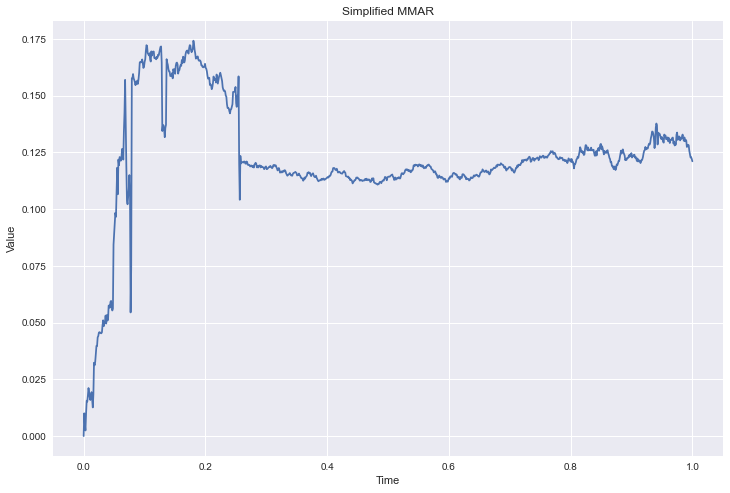

In [21]:
def generate_multifractal_measure(hurst, num_intervals):
    """
    This function generates a multifractal measure using a multiplicative cascade.
    The weights of the subintervals are correlated, and their correlation is controlled by the Hurst parameter.
    """
    
    # Initialize measure with one interval [0, 1]
    measure = [(0, 1)]
    
    for _ in range(num_intervals):
        # Choose a random interval from measure
        index = np.random.randint(len(measure))
        a, b = measure.pop(index)
        
        # Choose a random point in the interval according to Beta distribution
        split_point = np.random.beta(a=hurst, b=hurst)
        
        # Add new intervals to measure
        measure.append((a, a + split_point * (b - a)))
        measure.append((a + split_point * (b - a), b))
    
    # Sort measure by interval start time
    measure.sort(key=lambda x: x[0])
    
    return measure

def generate_MMAR(hurst, num_intervals, mu, sigma, T, N):
    """
    This function generates a time series using the MMAR.
    """
    
    # Generate multifractal measure
    measure = generate_multifractal_measure(hurst, num_intervals)
    
    # Initialize MMAR
    MMAR = np.zeros(N)
    dt = T/N
    time_stamps = np.linspace(0, T, N)
    
    # Apply measure to time series
    for i in range(1, N):
        for a, b in measure:
            if a <= time_stamps[i] < b:
                MMAR[i] = MMAR[i-1] + np.sqrt(dt / (b - a)) * np.random.normal(mu * dt, sigma * np.sqrt(dt))
        
        # Correction step to ensure MMAR doesn't go negative
        if MMAR[i] < 0:
            MMAR[i] = 0.01  # Correcting to a small positive value
    
    return MMAR


# Set the parameters
hurst = 0.60
num_intervals = 252
mu = 0.1
sigma = 0.40
T = 1
N = 1000

# Generate MMAR
MMAR = generate_MMAR(hurst, num_intervals, mu, sigma, T, N)

# Plot the MMAR
plt.figure(figsize=(12, 8))
plt.plot(np.linspace(0, T, N-1), MMAR[:-1])
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Simplified MMAR')
plt.show()

With this model, we are able to produce price charts that resemble real asset asset prices, but that are not realistic enough just yet. We make the following simplifications relatively to the MMAR:  
  
1 - Mandelbrot's MMAR employs a much more intricate procedure for the multifractal measure construction, using binomial cascades to generate a range of measures.   
2 - In Mandelbrot's MMAR, volatility is governed by trading time which evolves in a multifractal fashion while this model only applies the cascade to regular calendar time.  
3 - MMAR involves several more parameters to capture various features of timeseries behavior.  
4 - MMAR does not inherently prevent prices from going negative (like we are doing here).  

#### 3.3. An Attempt at a More Sophisticated Multifractal Generator

Now, for a slightly more realistic representation, we'll add the parameters alpha and beta to the multifractal measure, making sure that the interval weights are influenced by H, making the model more sensitive to long-term memory. We'll also implement time-varying volatility, as a function of trading time, similar to what is proposed by the MMAR. 

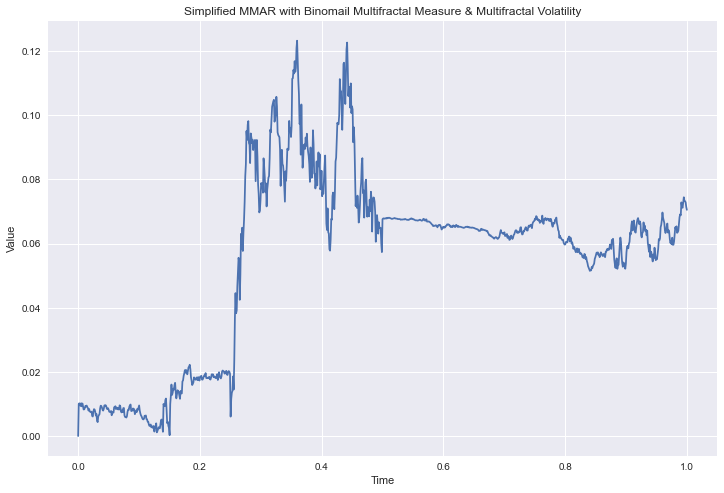

In [22]:
def generate_multifractal_measure(hurst, num_intervals):
    """
    This function generates a binomial multifractal measure using a multiplicative cascade.
    """
    alpha = 0.5 + hurst / 2
    beta = 0.5 - hurst / 2
    
    # Initialize measure with one interval [0, 1] and weight 1
    measure = [(0, 1, 1)]
    
    for _ in range(num_intervals):
        # Choose a random interval from measure
        index = np.random.randint(len(measure))
        a, b, w = measure.pop(index)
        
        # Generate a binomial random variable
        p = np.random.binomial(n=1, p=0.5)
        
        # Calculate new weights
        w_alpha = w * alpha if p == 1 else w * beta
        w_beta = w * beta if p == 1 else w * alpha
        
        # Add new intervals to measure
        measure.append((a, a + 0.5 * (b - a), w_alpha))
        measure.append((a + 0.5 * (b - a), b, w_beta))
    
    # Sort measure by interval start time
    measure.sort(key=lambda x: x[0])
    
    return measure

def generate_MMAR(hurst, num_intervals, mu, sigma, T, N):
    """
    This function generates a time series using the MMAR, with volatility as a function of the trading time.
    """
    # Generate multifractal measure
    measure = generate_multifractal_measure(hurst, num_intervals)
    
    # Initialize MMAR
    MMAR = np.zeros(N)
    dt = T / N
    time_stamps = np.linspace(0, T, N)
    
    # Apply measure to time series
    for i in range(1, N):
        for a, b, w in measure:
            if a <= time_stamps[i] < b:
                dW = np.random.normal(0, np.sqrt(dt))
                volatility = sigma * np.sqrt(w)
                MMAR[i] = MMAR[i-1] + mu * w * dt + volatility * dW
        # Correction step to ensure MMAR doesn't go negative
        if MMAR[i] < 0:
            MMAR[i] = 0.01  # Correcting to a small positive value
        
    return MMAR

# Set the parameters
hurst = 0.75
num_intervals = 10
mu = 0.1
sigma = 0.2
T = 1
N = 1000

# Generate MMAR
MMAR = generate_MMAR(hurst, num_intervals, mu, sigma, T, N)

# Plot the MMAR
plt.figure(figsize=(12, 8))
plt.plot(np.linspace(0, T, N-1), MMAR[:-1])
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Simplified MMAR with Binomail Multifractal Measure & Multifractal Volatility')
plt.show()

After producing some simplified versions of the model to illustrate its workings and main components, we will use Crude Oil's data to calculate the necessary parameters for a yet more realistic version of the MMAR proposed by Mandelbrot, using the parameters found in the real data. 

### 4. Calculating the necessary Fractal Parameters for the Simulations

We will be loading a longer price series of WTI prices as the yahoo finance API had limited datapoints. 

The steps to calculate the fractal parameters are as follows:

1. Get a highly composite number of data points (7560 in this case)
2. Generate $\Delta t$ (or $dt$) which are the time increments
3. Generate the statistical moments $q$ that will be used for the partition function.
4. Calculate the partition function for different values of $dt$ and $q$
5. Calculate the scaling function $\tau_q$ (the regressions of the partition functions). Use lower moments. 
6. Estimate the precise value of $H$
7. Calculate $\alpha_0$
8. Calculate $\lambda$ and $\sigma^2$

#### 4.1. Obtain and Format Data

In [23]:
prices_ = pd.read_csv('wti_2nb_price_data.csv', index_col=0, parse_dates=True)

In [30]:
prices_data = prices.copy()

In [31]:
close_return = np.log(prices_data/prices_data.shift())
close_return = close_return.dropna()

C:\Users\lucas\anaconda3\envs\main_clone_test_old_pandas\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [32]:
prices_data_train = prices.iloc[:-30]
prices_data_test = prices.iloc[-30:]

#### 4.2. Raw Statistical Moments

In [33]:
# Define the sequence ranges
# Select the values of q
# The q here

q = np.linspace(0.01, 3, 120) # up to a value with a quadratic shape
q

array([0.01      , 0.03512605, 0.0602521 , 0.08537815, 0.1105042 ,
       0.13563025, 0.1607563 , 0.18588235, 0.2110084 , 0.23613445,
       0.2612605 , 0.28638655, 0.31151261, 0.33663866, 0.36176471,
       0.38689076, 0.41201681, 0.43714286, 0.46226891, 0.48739496,
       0.51252101, 0.53764706, 0.56277311, 0.58789916, 0.61302521,
       0.63815126, 0.66327731, 0.68840336, 0.71352941, 0.73865546,
       0.76378151, 0.78890756, 0.81403361, 0.83915966, 0.86428571,
       0.88941176, 0.91453782, 0.93966387, 0.96478992, 0.98991597,
       1.01504202, 1.04016807, 1.06529412, 1.09042017, 1.11554622,
       1.14067227, 1.16579832, 1.19092437, 1.21605042, 1.24117647,
       1.26630252, 1.29142857, 1.31655462, 1.34168067, 1.36680672,
       1.39193277, 1.41705882, 1.44218487, 1.46731092, 1.49243697,
       1.51756303, 1.54268908, 1.56781513, 1.59294118, 1.61806723,
       1.64319328, 1.66831933, 1.69344538, 1.71857143, 1.74369748,
       1.76882353, 1.79394958, 1.81907563, 1.84420168, 1.86932

In [34]:
from IPython.core.display import display, HTML

display(HTML("<style>div.output_scroll { height: auto; }</style>"))

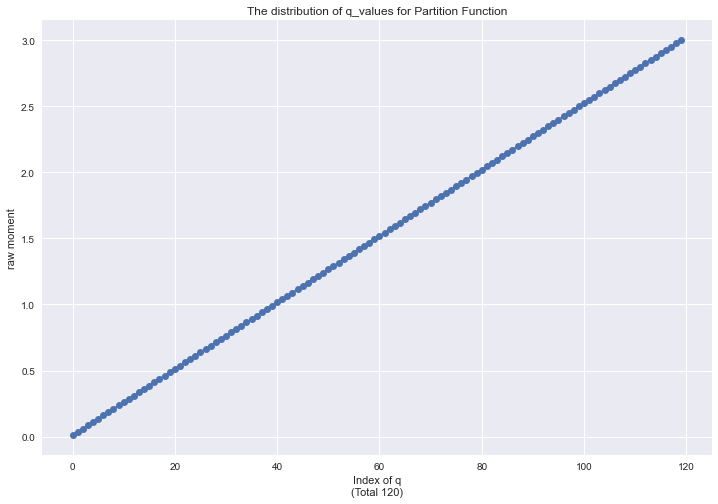

In [35]:
# Plotting q_values
plt.figure(figsize=(12,8))
plt.grid(True)
plt.title("The distribution of q_values for Partition Function")
plt.xlabel(f"Index of q\n(Total {len(q)})")
plt.ylabel('raw moment')
plt.plot(q, marker='o')
plt.show()

#### 4.3. Partition Function

In summary, the Chhabra-Jensen method uses the partition function to characterize scaling behavior and then Legendre transforms this to derive the multifractal spectrum.

In [36]:
min_window = 10
max_window = len(prices_data_train)
print('length of the training prices data: ', len(prices_data_train))

window_sizes = list(map(
        lambda x: int(10**x), # NOTE: in the paper, it said the window should be 2**n instead of 10**n
        np.arange(math.log10(min_window), math.log10(max_window), 0.25)))
window_sizes

length of the training prices data:  5707


[10, 17, 31, 56, 100, 177, 316, 562, 1000, 1778, 3162, 5623]

In [37]:
def partition_function(delta, x_t, q):
    '''
    @params
    delta array: time interval range
    x_t array: the time series
    q float: the power q
    '''
    # Initialize a 2D array sigma to store the partition function values.
    # row for different delta
    Fq = [[0 for x in range(len(delta))] for y in range(len(q))]
    
    # Loop through each exponent q[k] and time lag delta[j].
    # For each q and delta, compute the partition function by:
    # i) Iterating through the time series in chunks of size delta[j]
    # ii) Calculating the absolute difference between each point and the point delta[j] steps ahead
    # iii) Summing the q[k] power of these differences
    for k in range (0, len(q)):
        if k%30==0: # dividable by 30
            print("calculating q=" + str(k) + ' out of ' + str(len(q)-1))
            
        for j in range (0,len(delta)):
            
            for i in range (0,len(x_t)-1):
                if i < int((len(x_t)-1)/delta[j]):
                    Fq[k][j]=Fq[k][j] + abs(x_t[i*delta[j]+delta[j]]-x_t[i*delta[j]])**q[k]

    Fq=pd.DataFrame(Fq)

    for i in range(0,len(q)):
        Fq.rename(index={Fq.index[i]:q[i]}, inplace=True)
    for i in range(len(delta)-1,-1,-1):
        Fq.rename(columns={Fq.columns[i]:delta[i]}, inplace=True)

    print("Finished. Return Fq...")
    return Fq

In [38]:
Fq = partition_function(window_sizes, prices_data_train, q)

calculating q=0 out of 119
calculating q=30 out of 119
calculating q=60 out of 119
calculating q=90 out of 119
Finished. Return Fq...


In [39]:
Fq

,10,17,31,56,100,177,316,562,1000,1778,3162,5623
0.010000,574.199069,338.557241,186.454700,102.567594,57.987579,3.273824e+01,18.457816,10.262990,5.123352,3.039287,1.042018,1.039347
0.035126,585.201444,347.836527,192.874896,106.683613,60.590000,3.470036e+01,19.670754,10.962584,5.457136,3.147290,1.155550,1.145178
0.060252,596.864841,357.620671,199.670304,111.065446,63.374061,3.682555e+01,20.979208,11.721509,5.827548,3.269415,1.281453,1.261786
0.085378,609.209099,367.931558,206.859499,115.729436,66.351217,3.912684e+01,22.391131,12.544898,6.238002,3.406792,1.421072,1.390267
0.110504,622.255800,378.792571,214.462398,120.693262,69.533949,4.161845e+01,23.915175,13.438341,6.692271,3.560675,1.575904,1.531831
...,...,...,...,...,...,...,...,...,...,...,...,...
2.899496,105337.345460,143275.351159,139260.327793,309398.730867,481758.710102,8.467618e+05,315394.045614,184473.040788,348991.279471,80454.231300,152384.069927,72395.088285
2.924622,112471.785498,154025.471171,149797.481147,337603.674407,533222.020132,9.413848e+05,346641.758198,202301.403288,387460.482220,88721.235774,168986.951300,79766.713399
2.949748,120125.507836,165624.561400,161160.586588,368435.869351,590293.846745,1.046763e+06,381009.212663,221866.390271,430184.897319,97838.058881,187398.785997,87888.953757
2.974874,128338.404539,178142.204712,173416.162963,402144.119888,653594.227516,1.164135e+06,418809.739830,243338.352431,477636.514939,107892.072756,207816.667044,96838.240706


In [40]:
# Power-law regression on log Fq(n) vs log delta to get scaling exponent τ(q)
# If the signal has scaling properties, Fq(n) will follow a power law:
# Fq(n) ~ n^τ(q)
tau_q_list = []
for i,row in Fq.iterrows():
    Fq_matrix = np.vstack([np.log10(row.values), np.ones(len(row))]).T
    tau_q, c = np.linalg.lstsq(Fq_matrix, np.log10(window_sizes), rcond=-1)[0]
    tau_q_list.append(tau_q)

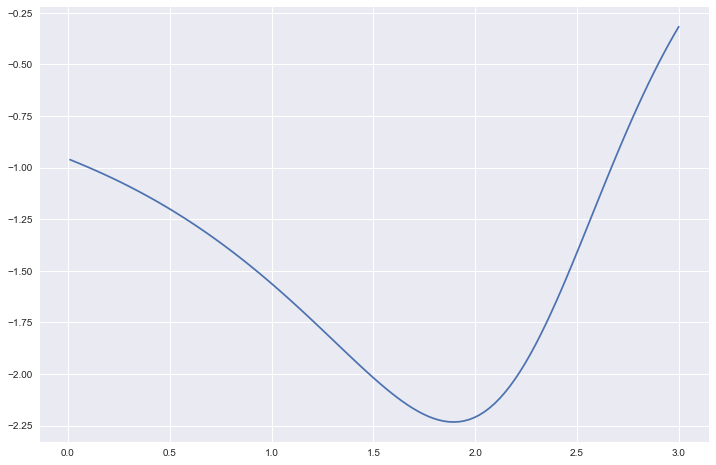

In [41]:
# plot τ(q) with q
# Monofractal signals show a linear τ(q) curve. The slope gives the single Hurst exponent H.
# Multifractal τ(q) curves are nonlinear. The curvature reveals richer structure.
plt.figure(figsize=(12, 8))
plt.plot(Fq.index, tau_q_list)

#### 4.4. The Hurst Exponent H

In [1]:
from hurst import compute_Hc, random_walk

ModuleNotFoundError: No module named 'hurst'

In [48]:
from hurst import compute_Hc, random_walk
H, c, data = compute_Hc(prices_data_train, kind='price', simplified=False)
H = oil_H

ModuleNotFoundError: No module named 'hurst'

In [51]:
## CANNOT USE the hurst package, using the H calcuted above instead
H = h_oil

#### 4.5. Estimating the Multifractal Spectrum f(a)
- Legendre transform τ(q) to get f(α) Multifractal spectrum:
- By scanning over different values of q, we can trace out the multifractal spectrum f(α).

In [44]:
def estimate_multifractal_spectrum(TAU_Q, Q, MIN_Q, MAX_Q):
    TAU_Q_ESTIMATED = np.polyfit(Q[MIN_Q:MAX_Q], TAU_Q[MIN_Q:MAX_Q], 2)

    F_A = [0 for x in range(len(q)-10)]
    p = [0 for x in range(len(q)-10)]

    a = TAU_Q_ESTIMATED[0]
    b = TAU_Q_ESTIMATED[1]
    c = TAU_Q_ESTIMATED[2]

    for i in range(0, len(q)-10):
        p[i] = 2*a*Q[i]+b
        F_A[i] = ((p[i]-b)/(2*a))*p[i] - (a*((p[i]-b)/(2*a))**2 + b*((p[i]-b)/(2*a)) + c)

    F_A = pd.DataFrame(F_A)
    F_A.rename(columns={F_A.columns[0]:"f(a)"}, inplace=True)
    F_A['p'] = p

    print("Using the range of q's from " + str(Q[MIN_Q]) + " to " + str(Q[MAX_Q]) + ":")
    # TAU_Q_ESTIMATED are the coefficients (a,b,c) from fitting the quadratic model to τ(q).
    print("The estimated parameters for tau(q) are: \n" + str(TAU_Q_ESTIMATED))
    
    # the three estimated parameters for f(a) are derived from the Legendre transform relations:
    # i) 1/(4*a) is the width of the f(α) spectrum
    width_of_spectrum = 1/(4*a)
    # ii) (-2b)/(4a) is the position of the peak α0 == most probable Hölder exponent
    holder_exponent = (-2*b)/(4*a)
    # iii) (-4ac+b^2)/(4*a) is related to asymmetry in f(α)
    asymmetry_of_spectrum = (-4*a*c+b**2)/(4*a)
    # they give key properties of f(α) spectrum
    print("\nThus, the estimated parameters for f(a) are: \n width_of_spectrum: " + str(width_of_spectrum) + ", \n holder_exponent: "  + str(holder_exponent) + ", \n asymmetry_of_spectrum: "+ str(asymmetry_of_spectrum))

    return F_A, (width_of_spectrum, holder_exponent, asymmetry_of_spectrum)

In [45]:
F_A, parameters_of_spectrum = estimate_multifractal_spectrum(tau_q_list, q, 0, len(q)-1)

Using the range of q's from 0.01 to 3.0:
The estimated parameters for tau(q) are: 
[ 0.66908211 -2.04440568 -0.46286365]

Thus, the estimated parameters for f(a) are: 
 width_of_spectrum: 0.37364621681430354, 
 holder_exponent: 1.5277688928626163, 
 asymmetry_of_spectrum: 2.0245533481012035


#### 4.6. Finding the most probable Hölder exponent.

- The width of f(α) indicates degree of multifractality. α_min and α_max give range of Hölder exponents.

- The α at max f(α) gives the most probable Hölder exponent α0

- α0 = a for max[f(α)]

- Sibirtsev concludes, “The interpretation for α0 is this: if the data is multifractal —
meaning that it can have different Hölder exponents at different timepoints — then
α0 is the most commonly occurring, most “dominant” Hölder exponent in the price
data.”

The Hölder exponent indicates the local regularity or "smoothness" of a signal at a given point. It quantifies the scaling behavior and singularity strength. The Hölder exponent α measures how fast the signal is oscillating or changing as you zoom in.  

Larger exponent just implies higher order differentiability and smoothness in the signal's dynamics. The magnitude quantifies exactly how stable and noise-free it looks at finer scales.

In [46]:
# from the result above the
a0 = parameters_of_spectrum[1]
a0

1.5277688928626163

#### 4.7. Estimating the log-normal distribution parameters

In [52]:
# λ = α0 / H
simulated_lambda = a0 / H
print(simulated_lambda)

# σ2 = 2(λ — 1) / ln[b]
simulated_sigma = 2*(simulated_lambda - 1) / np.log(2)
print(simulated_sigma)

2.5410225011881993
4.4464510407250435


### 5. Running MMAR Simulations and Pricing Options via Monte Carlo

#### 5.1. Determining the number of data points to simulate

Here we are considering in using the binomial cascade, meaning that each interval is split into two each time (meaning b=2)

The simulation takes b*k data points. Therefore it is best to select b and k close to the desired number of data points. For example, if we want to simulate 7560 data points. When b = 2 and k = 13 he gets 8192 simulated data points to cover our need

In [53]:
# find the k when b == 2
display(len(prices_data_test))
K = math.ceil(np.log2(len(prices_data_test))) # k value
display(K)
display(2**K)

30

5

32

#### 5.2. Generating a log-normal multiplicative cascade

In summary, the code implements the theoretical lognormal cascade by recursively splitting, weighting, and branching the value v at each step.

At each step, it splits the value v into two parts, multiplies each by a random lognormal weight, and recursively cascades those parts. This matches the theoretical description of a multiplicative lognormal cascade:

- Splitting into two parts (b=2)
- Multiplying by random lognormal weights
- Cascading recursively in a branching way

In [54]:
def lognormal_cascade(k, v,ln_lambda, ln_theta):

    k = k - 1
    
    # FIXME: 
    # i) limit for the weight to avoid exponential weighting
    m0 = np.random.lognormal(ln_lambda,ln_theta)
    m1 = np.random.lognormal(ln_lambda,ln_theta)
    M = [m0, m1]

    if (k >= 0):
        d=[0 for x in range(0,2)]
        for i in range(0,2):
            d[i] = lognormal_cascade(k, (M[i]*v), ln_lambda, ln_theta)

        v = d

    return v

#### 5.3. Finding the trading time function θ(t)

In [55]:
new_cascade = list(np.array(lognormal_cascade(k=K, v=1, ln_lambda = simulated_lambda, ln_theta = simulated_sigma)).flat)
tradingtime = 2**K*np.cumsum(new_cascade)/sum(new_cascade)

The key is using the lognormal cascade to create a clustered, heavy-tailed distribution for θ(t). θ(t) maps the physical time t into a trading time scale

#### 5.4. Simulating a Fractional Brownian Motion

In [ ]:
# Sibirtsev describes, “I had to manually adjust the
# fBm “length” for each [market] until the median standard deviation of returns was
# approximately the same as that of the real data
# find the suitable magnitude_parameter by adjust the
# fBm “length” for each [market] until the median standard deviation of returns was
# approximately the same as that of the real data

In [56]:
%%time
magnitude_parameter = 2980
eps = 0.01
steps = 0.01
diff = np.inf
number_of_path = 20 # FIXME: if more simulated path is needed multiprocessing is needed
real_std = np.std(prices_data_train)

while abs(diff) > eps:
    std_list = []
#    for nb in tqdm(range(number_of_path)):
    for nb in range(number_of_path): # excluding tqdm for a less verbose output
        new_fbm_class = FBM(n = 10*2**K+1, hurst = H, length = magnitude_parameter, method='daviesharte')
        new_fbm_simulation = new_fbm_class.fbm()
        std_list.append(np.std(new_fbm_simulation))
    diff = real_std - np.median(std_list)
    #print('Diff: ', diff)
    if abs(diff) > eps:
        magnitude_parameter += diff * steps
    #    print('new magnitude_parameter:', magnitude_parameter)

100%|██████████| 20/20 [00:00<00:00, 188.02it/s]


#### 5.5. Calculating MMAR Returns and Prices

Firstly, we'll calculate the FBM part of the MMAR stochastic process:

In [76]:
number_of_path = 1000
returns_list = []
for nb in tqdm(range(number_of_path)):
    new_fbm_class = FBM(n = 10*2**K+1, hurst = H, length = magnitude_parameter, method='daviesharte')
    new_fbm_simulation = new_fbm_class.fbm()
    returns_list.append(new_fbm_simulation)
new_fbm_simulation = np.mean(returns_list, axis=0)

100%|██████████| 1000/1000 [00:04<00:00, 244.28it/s]


In [61]:
returns_frame = pd.DataFrame(returns_list)

In [62]:
returns_frame

,0,1,2,3,4,5,6,7,8,9,...,312,313,314,315,316,317,318,319,320,321
0,0.0,0.448350,2.506425,-1.564002,-1.757763,-0.001419,3.111796,-0.443067,0.269679,3.368641,...,122.247756,127.850369,124.263262,125.915422,130.596844,132.674573,136.541956,132.644854,134.103071,143.239919
1,0.0,0.866143,-0.756057,-4.264335,-4.352027,0.298178,-2.536703,-7.818888,-4.829484,-6.586351,...,-93.253006,-93.475475,-89.817548,-95.037872,-94.975113,-93.704811,-89.951863,-91.697721,-86.932461,-81.300654
2,0.0,-3.212829,-4.948397,-6.500864,-12.267950,-16.635944,-14.483170,-14.196542,-13.037823,-12.588200,...,-47.864188,-45.582271,-41.204582,-35.933297,-29.242866,-29.753783,-27.778838,-27.719684,-25.031766,-28.590542
3,0.0,-0.380764,3.916088,3.777073,-1.496484,0.922295,-3.090891,-6.547783,-6.273744,-5.996066,...,-55.312811,-53.365208,-44.531367,-45.123492,-43.101929,-44.181523,-41.654475,-40.769277,-38.047780,-38.237750
4,0.0,-0.441439,-1.822952,-4.991623,-7.734334,-7.645769,-7.086034,-9.652152,-8.142192,-12.433104,...,-44.301967,-38.623429,-41.915995,-34.291386,-32.395271,-35.595980,-28.912234,-30.243405,-26.545426,-22.305222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,-2.710995,4.042079,0.650254,2.293622,7.768133,5.063060,7.144392,12.257103,6.427174,...,-73.337238,-68.460260,-68.094368,-75.163947,-67.196236,-63.835680,-64.463119,-63.527860,-66.442060,-65.624282
996,0.0,3.685932,4.727007,3.112771,2.918837,6.464949,7.829052,7.310147,12.676897,3.292461,...,14.049578,13.564000,14.127588,16.460836,18.544028,20.932230,22.881905,21.976135,23.210211,26.843202
997,0.0,0.146573,-0.157574,-0.191560,0.674386,1.929307,5.796287,1.265684,4.951450,7.732191,...,193.105109,189.649522,187.842918,185.153219,184.209832,186.775044,187.355164,186.470268,185.716479,188.882741
998,0.0,-9.289007,-8.173510,-8.268780,-7.616349,-5.520478,-7.403813,-9.065341,-6.592140,-5.990803,...,24.475621,20.884986,21.404294,18.931599,18.013755,15.879858,9.995560,9.696276,9.787267,7.289848


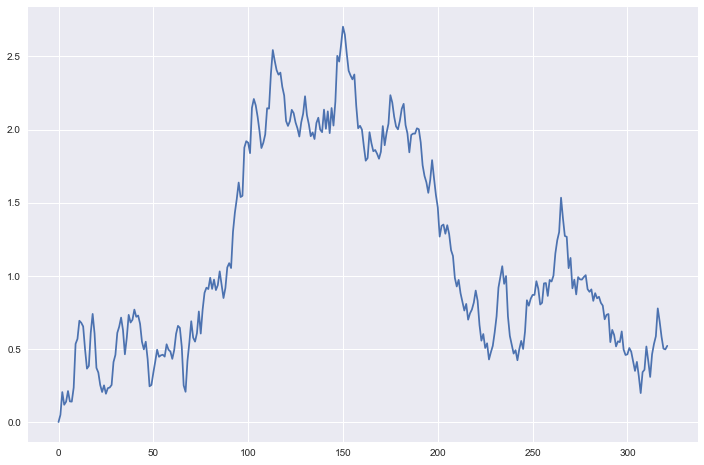

In [80]:
plt.figure(figsize=(12, 8))
plt.plot(new_fbm_simulation)
plt.show()

Secondly, we'll produce the trading time part of the stochastic process. Remember that the MMAR proposes a compound FBM/Trading Time stochastic process.

C:\Users\lucas\AppData\Local\Temp/ipykernel_12776/2209668137.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


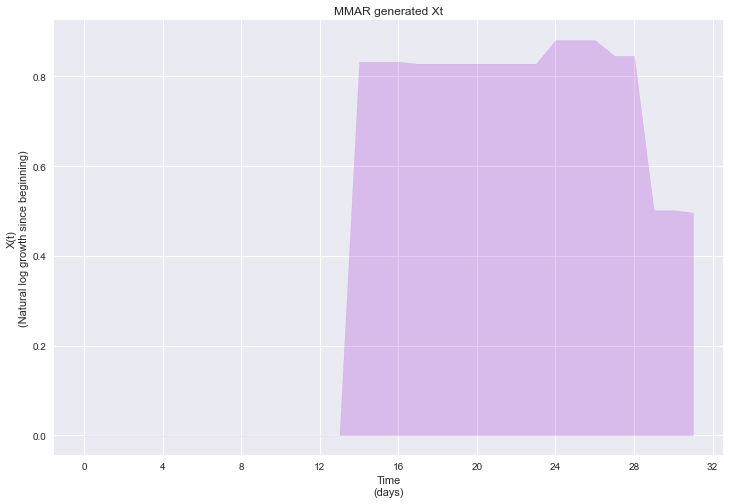

In [82]:
# --- MMAR returns's ---
simulated_xt_array = [0 for x in range(0, len(tradingtime))]

for i in range(0, len(tradingtime)):
    simulated_xt_array[i] = new_fbm_simulation[int(tradingtime[i]*10)]
plt.figure(figsize=(12, 8))
plt.title("MMAR generated Xt")
plt.xticks(np.arange(0, 2**(K)+1, 2**(K-3)))
plt.xlabel("Time\n(days)")
plt.ylabel('X(t)\n(Natural log growth since beginning)')
plt.grid(b=True)
plt.fill_between(np.arange(0, 2**K, 1) , simulated_xt_array, color="darkviolet", alpha=0.2)
plt.show()

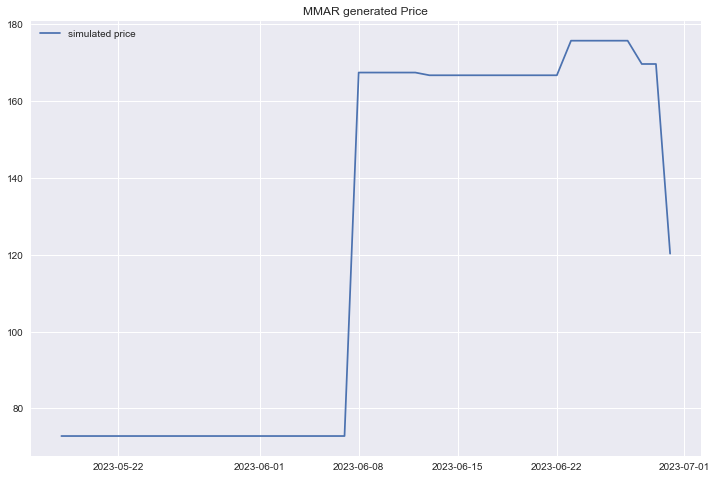

In [86]:
# --- PRICES ---
simulated_prices_array = prices_data_train.values[-1]*np.exp(simulated_xt_array[:len(prices_data_test)])
compound_process = pd.Series(simulated_prices_array, index=prices_data_test.index)
plt.figure(figsize=(12, 8))
plt.plot(compound_process, label='simulated price')
plt.title("MMAR generated Price")
plt.legend()

#### 5.6. Estimating the Option Payoff

In [87]:
# parameters
S0 = prices_data_train.values[-1]  
strike_p = S0
r = 0.05
T = 1.0

In [88]:
call_payoff = np.exp(-r*T) * np.maximum(simulated_prices_array[-1] - strike_p, 0)  
put_payoff = np.exp(-r*T) * np.maximum(strike_p - simulated_prices_array[-1], 0) 
print("Call option price: ", call_payoff)
print("Put option price: ", put_payoff)

Call option price:  45.17834085822344
Put option price:  0.0


In [91]:
# simulate price paths and calculate payoffs
call_payoffs = []
put_payoffs = []
returns_list = []
prices_paths = []
for nb in tqdm(range(number_of_path)):
    new_fbm_class = FBM(n = 10*2**K+1, hurst = H, length = magnitude_parameter, method='daviesharte')
    new_fbm_simulation = new_fbm_class.fbm()
    returns_list.append(new_fbm_simulation)
    
    # --- MMAR returns's ---
    simulated_xt_array = [0 for x in range(0, len(tradingtime))]
    for i in range(0, len(tradingtime)):
        simulated_xt_array[i] = new_fbm_simulation[int(tradingtime[i]*10)]
        
    # --- PRICES ---
    simulated_prices_array = S0*np.exp(simulated_xt_array[:len(prices_data_test)])
    prices_paths.append(simulated_prices_array)
    
    call_payoff = np.maximum(simulated_prices_array[-1] - strike_p, 0)  # Calls
    call_payoffs.append(call_payoff)
    
    put_payoff = np.maximum(strike_p - simulated_prices_array[-1], 0)  # Puts
    put_payoffs.append(put_payoff)

# Calculate the option price as the average discounted payoff
call_option_price = np.exp(-r*T) * np.mean(call_payoffs)
put_option_price = np.exp(-r*T) * np.mean(put_payoffs)

print("Call option price: ", call_option_price)
print("Put option price: ", put_option_price)

100%|██████████| 1000/1000 [00:04<00:00, 244.45it/s]

Call option price:  1.0176449372886818e+151
Put option price:  36.26691495664702


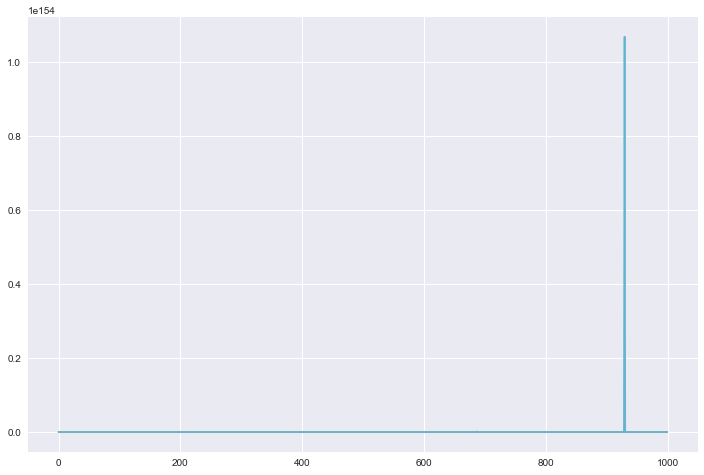

In [94]:
plt.figure(figsize=(12, 8))
plt.plot(prices_paths)
plt.show()

####  5.7 Alternative Paths Generator & Option Pricer 

In [114]:
def mmr_single_path(N, sigma, lambda_, H, f_a, s0=80):
    
    path = np.zeros(N)
    path[0] = s0
    W = np.random.normal(0, 1, N)
    
    for t in range(1, N):
        # MMAR model equation
        path[t] = path[t-1] + sigma * np.exp(-lambda_ * path[t-1]) * W[t]
    
    return path

def simulate_mmar_paths(H, f_a, sigma, lambda_, T=1.0, N=1000, num_paths=100, s0=80):
    paths = []
    for _ in range(num_paths):
        path = mmr_single_path(N, sigma, lambda_, H, f_a, s0=s0)
        paths.append(path)
    return paths

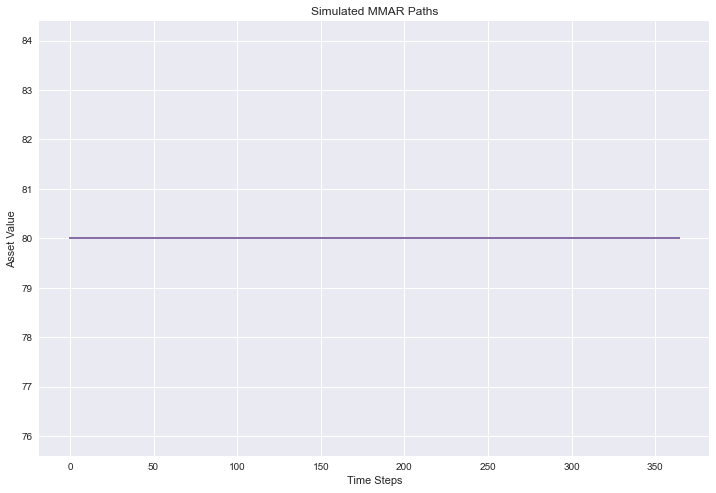

In [118]:
def plot_mmar_paths(paths):
    plt.figure(figsize=(12, 8))
    
    for path in paths:
        plt.plot(path)
    
    plt.title('Simulated MMAR Paths')
    plt.xlabel('Time Steps')
    plt.ylabel('Asset Value')
    plt.grid(True)
    plt.show()

# Define your parameters
H = 0.60   # Hurst Exponent
f_a = 100  # Multifractal Spectrum
sigma = 300  # sigma value
lambda_ = 1000  # lambda value
N = 365  # Time series length
num_paths = 100  # Number of paths to simulate

# Generate MMAR paths
paths = simulate_mmar_paths(H, f_a, sigma, lambda_, N=N, num_paths=num_paths)

# Plot the paths
plot_mmar_paths(paths)

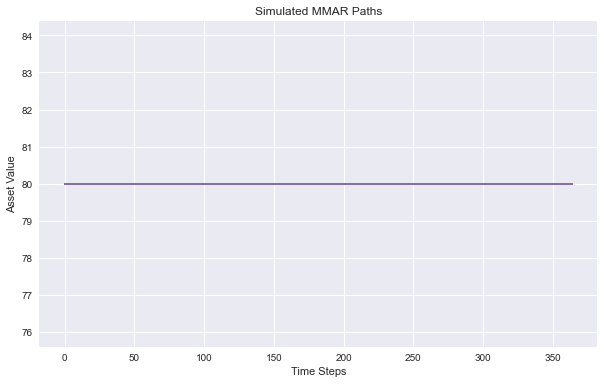

In [109]:
# Define your parameters
H = h_oil  # Hurst Exponent
f_a = a0  # Multifractal Spectrum
sigma = simulated_sigma  # sigma value
lambda_ = simulated_lambda  # lambda value
N = 365  # Time series length
num_paths = 100  # Number of paths to simulate
s0 = 80  # Starting value

# Generate MMAR paths
paths = simulate_mmar_paths(H, f_a, sigma, lambda_, N=N, num_paths=num_paths, s0=s0)

# Plot the paths
plot_mmar_paths(paths)


#### An initial look at The existing python package

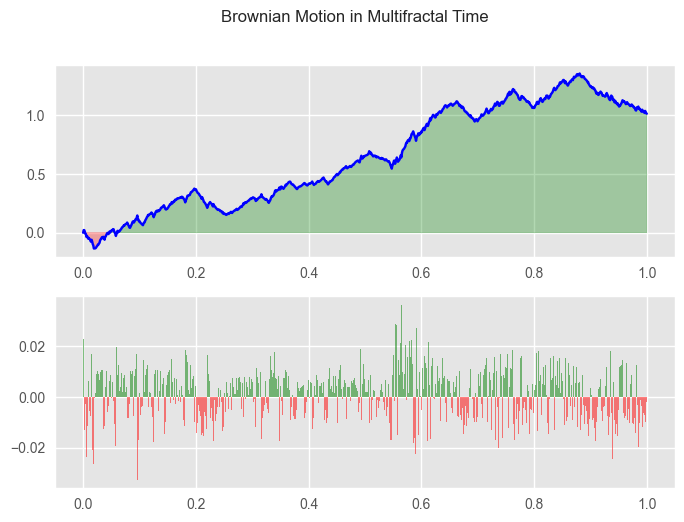

In [77]:
from fractalmarkets.mmar.brownian_motion_multifractal_time import BrownianMotionMultifractalTime
import matplotlib
import matplotlib.pyplot as plt; plt.style.use('ggplot')
from scipy import interpolate
import numpy as np

bmmt = BrownianMotionMultifractalTime(9, x=0.457, y=0.603, randomize_segments=True, randomize_time=True, M=[0.6, 0.4])
data = bmmt.simulate() # [ [x, y], ..., [x_n, y_n]]

f = interpolate.interp1d(data[:,0], data[:,1])

y = f(np.arange(0, 1, .001))
x = np.linspace(0, 1, len(y), endpoint=True)

y_diff = [b - a for a, b in zip(y[:-1], y[1:])]

fig, axs = plt.subplots(2)
fig.suptitle('Brownian Motion in Multifractal Time')

axs[0].plot(x, y, 'b-')
axs[1].bar(x[:-1],y_diff,align='edge',width=0.001,alpha=0.5)
bar_list=filter(lambda x: isinstance(x,matplotlib.patches.Rectangle),axs[1].get_children())
for bar,ret in zip(bar_list,y_diff):
    if ret >= 0:
        bar.set_facecolor('green')
    else:
        bar.set_facecolor('red')

z1 = np.array(y)
z2 = np.array([0] * len(y))

axs[0].fill_between(x, y, 0,
                where=(z1 >= z2),
                alpha=0.30, color='green', interpolate=True)

axs[0].fill_between(x, y, 0,
                where=(z1 < z2),
                alpha=0.30, color='red', interpolate=True)

plt.show()